In [1]:
import pandas as pd

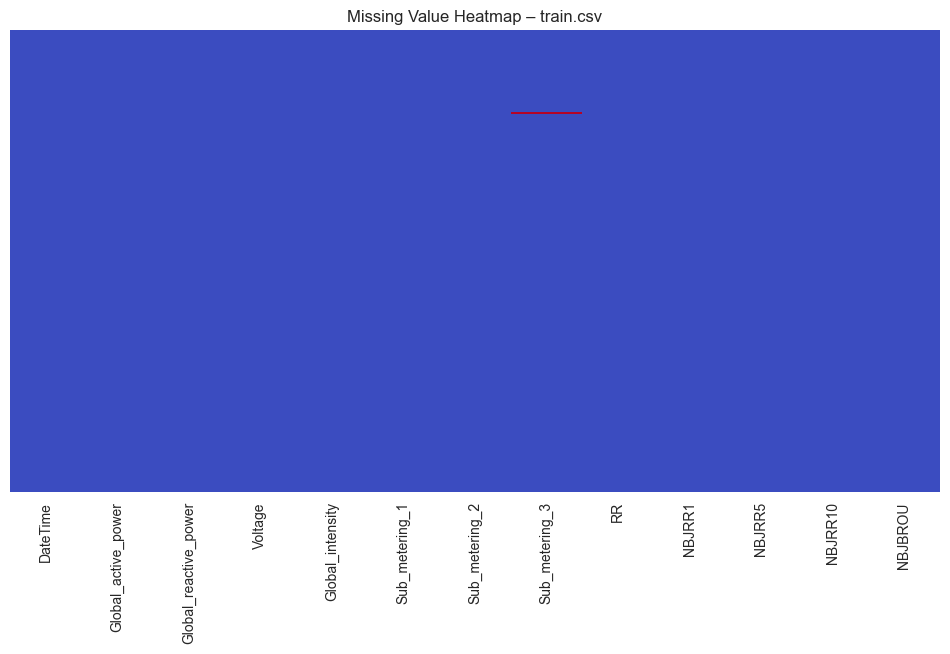

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv', parse_dates=['DateTime'])

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(),
            cbar=False,
            cmap='coolwarm',     # 可替换为 'cividis', 'coolwarm', 'Blues', 'YlGnBu' 等
            yticklabels=False)
plt.title('Missing Value Heatmap – train.csv')
plt.savefig('missing_heatmap_train.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\51915\AppData\Local\Temp\ipykernel_6884\1411776556.py:13: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('test.csv', header=None, names=COLUMN_NAMES, parse_dates=['DateTime'])


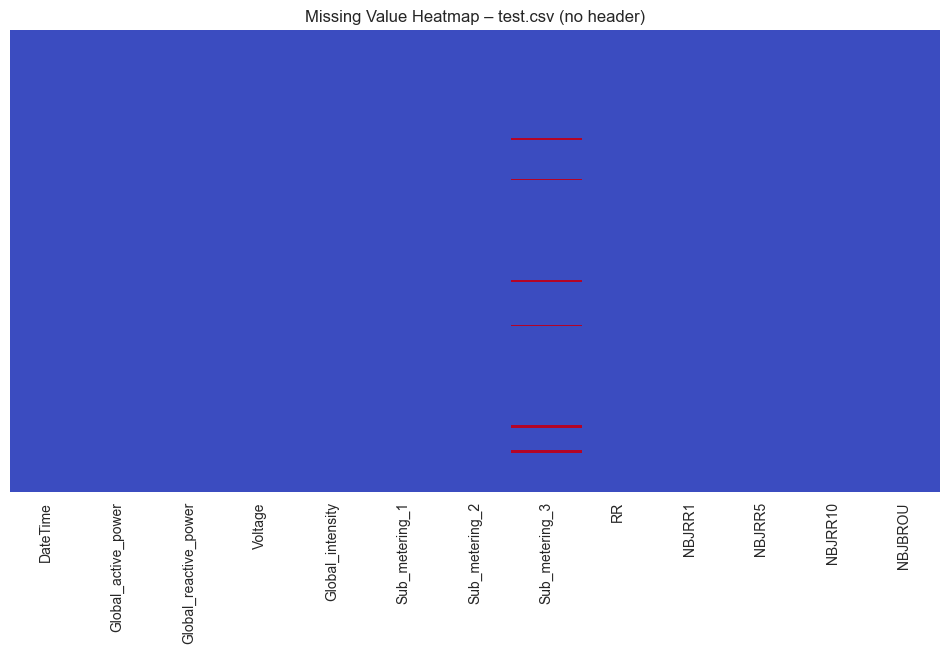

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 定义列名 （和你 train.csv 的列名一致）
COLUMN_NAMES = [
    'DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
]

# 读取 test.csv，指定 header=None 并设置列名
df_test = pd.read_csv('test.csv', header=None, names=COLUMN_NAMES, parse_dates=['DateTime'])

# 绘制缺失值热力图
plt.figure(figsize=(12, 6))
sns.heatmap(df_test.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
plt.title('Missing Value Heatmap – test.csv (no header)')
plt.savefig('pics/missing_heatmap_test.png', dpi=300, bbox_inches='tight')
plt.show()


In [2]:
# 假设你已经成功加载了 train.csv 并且它有正确的表头
train_df_sample = pd.read_csv("train.csv", nrows=1) # 只读一行来获取列名，高效
COLUMN_NAMES = train_df_sample.columns.tolist()

print("正确的列名是:")
print(COLUMN_NAMES)
# 预期输出: ['DateTime', 'Global_active_power', 'Global_reactive_power', ...]

正确的列名是:
['DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU']


In [3]:
import pandas as pd

def preprocess_power_data(filepath, output_path, has_header=True):
    """
    将分钟级别电力数据聚合为日级别。
    - Global_active_power 等瞬时值 → 日均
    - sub_metering_x 等能量值 → 日累计
    """
    COLUMN_NAMES = [
        'DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
        'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
    ]

    if has_header:
        df = pd.read_csv(filepath)
    else:
        df = pd.read_csv(filepath, header=None, names=COLUMN_NAMES)

    # 统一数据类型
    cols_to_numeric = COLUMN_NAMES[1:]
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)

    # 计算 sub_metering_remainder_per_min 单位 Wh
    df['sub_metering_remainder_per_min'] = (df['Global_active_power'] * 1000 / 60) - (
        df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
    )
    df['sub_metering_remainder_per_min'] = df['sub_metering_remainder_per_min'].clip(lower=0)

    # 聚合规则
    aggregation_rules = {
        'Global_active_power': 'mean',
        'Global_reactive_power': 'mean',
        'Voltage': 'mean',
        'Global_intensity': 'mean',
        'Sub_metering_1': 'sum',
        'Sub_metering_2': 'sum',
        'Sub_metering_3': 'sum',
        'sub_metering_remainder_per_min': 'sum',
        'RR': 'first',
        'NBJRR1': 'first',
        'NBJRR5': 'first',
        'NBJRR10': 'first',
        'NBJBROU': 'first'
    }

    daily_df = df.resample('D').agg(aggregation_rules)
    daily_df['RR'] = daily_df['RR'] / 10  # 转毫米单位
    daily_df.ffill(inplace=True)

    daily_df.to_csv(output_path)
    print(f"完成: {output_path}")
    print(daily_df.head())
    print(daily_df.describe())
    return daily_df


# ========== 实际调用 ==========
print("处理 train.csv...")
preprocess_power_data("train.csv", "train_daily.csv", has_header=True)

print("\n处理 test.csv...")
preprocess_power_data("test.csv", "test_daily.csv", has_header=False)


处理 train.csv...
完成: train_daily.csv
            Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                             
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
DateTime                                                                       
2006-12-16         13.082828             0.0           546.0          4926.0   
2006-12-17          9.999028          2033.0          4187.0         13341.0   
2006-12-18          6.421667          1063.0          2621.0         14018.0   
2006-12-19          4.926389           839.0          7602.0          619

C:\Users\51915\AppData\Local\Temp\ipykernel_27792\4055593468.py:18: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None, names=COLUMN_NAMES)


完成: test_daily.csv
            Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                             
2009-01-01             0.976869               0.078242  242.836062   
2009-01-02             1.616326               0.142174  242.704889   
2009-01-03             1.328817               0.121467  243.681458   
2009-01-04             1.347218               0.116207  244.822431   
2009-01-05             1.113889               0.089540  244.830778   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
DateTime                                                                       
2009-01-01          4.149861           765.0          3845.0          2803.0   
2009-01-02          6.737778          2417.0          6018.0         11841.0   
2009-01-03          5.530833          6440.0           328.0         10439.0   
2009-01-04          5.633194          1457.0          5251.0          3245.0   
2009-01-05

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remainder_per_min,RR,NBJRR1,NBJRR5,NBJRR10,NBJBROU
DateTime,,,,,,,,,,,,,
2009-01-01,0.976869,0.078242,242.836062,4.149861,765.0,3845.0,2803.0,16031.866667,5.124,10.0,4.2,1.4,0.6
2009-01-02,1.616326,0.142174,242.704889,6.737778,2417.0,6018.0,11841.0,18515.833333,5.124,10.0,4.2,1.4,0.6
2009-01-03,1.328817,0.121467,243.681458,5.530833,6440.0,328.0,10439.0,14684.600000,5.124,10.0,4.2,1.4,0.6
2009-01-04,1.347218,0.116207,244.822431,5.633194,1457.0,5251.0,3245.0,22380.233333,5.124,10.0,4.2,1.4,0.6
2009-01-05,1.113889,0.089540,244.830778,4.636250,1247.0,322.0,8650.0,16514.333333,5.124,10.0,4.2,1.4,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,1.417733,0.098857,240.197118,6.014167,4855.0,2110.0,10136.0,16924.600000,6.536,10.6,4.8,1.8,0.6
2010-11-23,1.095511,0.095451,240.575528,4.674444,1871.0,458.0,7611.0,16352.266667,6.536,10.6,4.8,1.8,0.6
2010-11-24,1.247394,0.091986,240.030965,5.249583,1096.0,2848.0,12224.0,13769.466667,6.536,10.6,4.8,1.8,0.6
